#### Import required libs

In [1]:
import sys
sys.path.append('/home/jupyter/app')

import numpy as np
import pandas as pd
import swifter

from tqdm.notebook import tqdm
from rdkit.Chem import Descriptors, MolFromSmiles


from src.io_utils import load_dataframe

#### Define constants

In [2]:
GS_DIR_RAW = "gs://pcqm4mv2/data/raw"
GS_DIR_FEATURES = "gs://pcqm4mv2/data/features"

SMILES_COLUMN = "smiles"

#### Load train set

In [3]:
df_train = load_dataframe("train.csv", GS_DIR_RAW)

print("df_train shape:", df_train.shape)
df_train.head()

df_train shape: (3378606, 2)


,smiles,homolumogap
idx,,
0,O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C,3.047675
1,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966
2,C=CCN(C(=O)C)/C=C/c1ccccc1C,4.639541
3,C=CCN(C(=O)C)/C=C/c1ccccc1F,4.492600
4,C=CCN(C(=O)C)/C=C/c1ccccc1Cl,4.612330


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3378606 entries, 0 to 3378605
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   smiles       object 
 1   homolumogap  float64
dtypes: float64(1), object(1)
memory usage: 77.3+ MB


#### Load validation set

In [5]:
df_val = load_dataframe("valid.csv", GS_DIR_RAW)

print("df_val shape:", df_val.shape)
df_val.head()

df_val shape: (73545, 2)


,smiles,homolumogap
idx,,
3378606,COc1ccccc1N[C@H](/C(=N\C(=N)O)/O)C,4.587840
3378607,COc1ccccc1N[C@H](/C(=N\C(=N)O)/O)C,4.971520
3378613,CC(/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S)C,5.496700
3378614,CC(/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S)C,5.485815
3378624,C/N=C(\c1cc2c(s1)ccc(c2)F)/O,4.748387


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73545 entries, 3378606 to 3746612
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   smiles       73545 non-null  object 
 1   homolumogap  73545 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


#### Visualizing molecules using RDKit

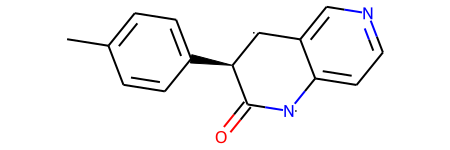

In [7]:
MolFromSmiles(df_train.loc[0, SMILES_COLUMN])

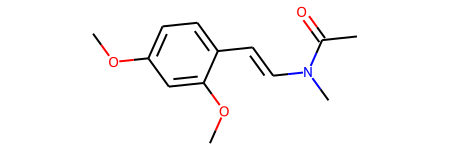

In [8]:
MolFromSmiles(df_train.loc[1, SMILES_COLUMN])

#### Feature Engineering

##### Create a customized RDKit descriptor

In [9]:
class NumberOfAtomsByAtomicNumber(Descriptors.PropertyFunctor):
    def __init__(self, atomic_number):
        Descriptors.PropertyFunctor.__init__(self, "NumberOfAtomsByAtomicNumber", "1.0.0")
        self.atomic_number = atomic_number

    def __call__(self, mol):
        filtered_list = filter(lambda atom: atom.GetAtomicNum() == self.atomic_number, mol.GetAtoms())
        return len(list(filtered_list))

##### Instantiate the customized descriptor for each element

In [10]:
number_of_B = NumberOfAtomsByAtomicNumber(atomic_number=5)
number_of_C = NumberOfAtomsByAtomicNumber(atomic_number=6)
number_of_N = NumberOfAtomsByAtomicNumber(atomic_number=7)
number_of_O = NumberOfAtomsByAtomicNumber(atomic_number=8)
number_of_F = NumberOfAtomsByAtomicNumber(atomic_number=9)
number_of_Si = NumberOfAtomsByAtomicNumber(atomic_number=14)
number_of_P = NumberOfAtomsByAtomicNumber(atomic_number=15)
number_of_S = NumberOfAtomsByAtomicNumber(atomic_number=16)
number_of_Cl = NumberOfAtomsByAtomicNumber(atomic_number=17)
number_of_Br = NumberOfAtomsByAtomicNumber(atomic_number=35)

#### Feature names

In [11]:
feature_names = [
    "number_of_atoms",
    "number_of_heavy_atoms",
    "number_of_bonds",
    "number_of_heavy_bonds",
    "number_of_conformations",
    "exact_mol_weight",
    "average_mol_weight",
    "heavy_mol_weight",
    "number_of_radical_electrons",
    "number_of_valence_electrons",
    "fp_morgan_density_1",
    "fp_morgan_density_2",
    "fp_morgan_density_3",
    "max_absolute_partial_charge",
    "min_absolute_partial_charge",
    "max_partial_charge",
    "min_partial_charge",
    "number_of_B_atoms",
    "number_of_C_atoms",
    "number_of_N_atoms",
    "number_of_O_atoms",
    "number_of_F_atoms",
    "number_of_Si_atoms",
    "number_of_P_atoms",
    "number_of_S_atoms",
    "number_of_Cl_atoms",
    "number_of_Br_atoms"
]

In [12]:
def extract_features(smiles):
    molecule = MolFromSmiles(smiles)
    
    return [
        molecule.GetNumAtoms(onlyExplicit=False),
        molecule.GetNumHeavyAtoms(),
        molecule.GetNumBonds(onlyHeavy=0),
        molecule.GetNumBonds(onlyHeavy=1),
        molecule.GetNumConformers(),
        Descriptors.ExactMolWt(molecule),
        Descriptors.MolWt(molecule),
        Descriptors.HeavyAtomMolWt(molecule),
        Descriptors.NumRadicalElectrons(molecule),
        Descriptors.NumValenceElectrons(molecule),
        Descriptors.FpDensityMorgan1(molecule),
        Descriptors.FpDensityMorgan2(molecule),
        Descriptors.FpDensityMorgan3(molecule),
        Descriptors.MaxAbsPartialCharge(molecule),
        Descriptors.MinAbsPartialCharge(molecule),
        Descriptors.MaxPartialCharge(molecule),
        Descriptors.MinPartialCharge(molecule),
        number_of_B(molecule),
        number_of_C(molecule),
        number_of_N(molecule),
        number_of_O(molecule),
        number_of_F(molecule),
        number_of_Si(molecule),
        number_of_P(molecule),
        number_of_S(molecule),
        number_of_Cl(molecule),
        number_of_Br(molecule)
    ]

In [13]:
train_features = df_train[SMILES_COLUMN].swifter.apply(extract_features)
val_features = df_val[SMILES_COLUMN].swifter.apply(extract_features)

Pandas Apply:   0%|          | 0/3378606 [00:00<?, ?it/s]

[22:12:29] WARNING: not removing hydrogen atom without neighbors
[22:12:29] WARNING: not removing hydrogen atom without neighbors
[22:12:29] WARNING: not removing hydrogen atom without neighbors
[22:13:54] WARNING: not removing hydrogen atom without neighbors
[22:13:54] WARNING: not removing hydrogen atom without neighbors
[22:15:36] WARNING: not removing hydrogen atom without neighbors
[22:15:36] WARNING: not removing hydrogen atom without neighbors
[22:15:36] WARNING: not removing hydrogen atom without neighbors
[22:15:56] Conflicting single bond directions around double bond at index 13.
[22:15:56]   BondStereo set to STEREONONE and single bond directions set to NONE.
[22:17:35] Conflicting single bond directions around double bond at index 11.
[22:17:35]   BondStereo set to STEREONONE and single bond directions set to NONE.


Pandas Apply:   0%|          | 0/73545 [00:00<?, ?it/s]

#### Convert features to a dataframe

In [24]:
df_train_features = pd.DataFrame(train_features.to_list(), columns=feature_names)
df_train_features.index.name = "idx"
df_train_features.index = df_train.index

df_val_features = pd.DataFrame(val_features.to_list(), columns=feature_names)
df_val_features.index.name = "idx"
df_val_features.index = df_val.index

#### Concatenate features with original columns (homolumogap and smiles)

In [25]:
df_train_features = pd.concat([df_train, df_train_features], axis=1)
df_val_features = pd.concat([df_val, df_val_features], axis=1)

#### Display dataframes with features

In [27]:
print("df_train_features shape:", df_train_features.shape)
df_train_features.head()

df_train_features shape: (3378606, 29)


,smiles,homolumogap,number_of_atoms,number_of_heavy_atoms,number_of_bonds,number_of_heavy_bonds,number_of_conformations,exact_mol_weight,average_mol_weight,heavy_mol_weight,...,number_of_B_atoms,number_of_C_atoms,number_of_N_atoms,number_of_O_atoms,number_of_F_atoms,number_of_Si_atoms,number_of_P_atoms,number_of_S_atoms,number_of_Cl_atoms,number_of_Br_atoms
idx,,,,,,,,,,,,,,,,,,,,,
0,O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C,3.047675,30,18,32,20,0,236.094963,236.274,224.178,...,0,15,2,1,0,0,0,0,0,0
1,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966,34,17,34,17,0,235.120843,235.283,218.147,...,0,13,1,3,0,0,0,0,0,0
2,C=CCN(C(=O)C)/C=C/c1ccccc1C,4.639541,33,16,33,16,0,215.131014,215.296,198.160,...,0,14,1,1,0,0,0,0,0,0
3,C=CCN(C(=O)C)/C=C/c1ccccc1F,4.492600,30,16,30,16,0,219.105942,219.259,205.147,...,0,13,1,1,1,0,0,0,0,0
4,C=CCN(C(=O)C)/C=C/c1ccccc1Cl,4.612330,30,16,30,16,0,235.076392,235.714,221.602,...,0,13,1,1,0,0,0,0,1,0


In [28]:
print("df_val_features shape:", df_val_features.shape)
df_val_features.head()

df_val_features shape: (73545, 29)


,smiles,homolumogap,number_of_atoms,number_of_heavy_atoms,number_of_bonds,number_of_heavy_bonds,number_of_conformations,exact_mol_weight,average_mol_weight,heavy_mol_weight,...,number_of_B_atoms,number_of_C_atoms,number_of_N_atoms,number_of_O_atoms,number_of_F_atoms,number_of_Si_atoms,number_of_P_atoms,number_of_S_atoms,number_of_Cl_atoms,number_of_Br_atoms
idx,,,,,,,,,,,,,,,,,,,,,
3378606,COc1ccccc1N[C@H](/C(=N\C(=N)O)/O)C,4.587840,32,17,32,17,0,237.111341,237.259,222.139,...,0,11,3,3,0,0,0,0,0,0
3378607,COc1ccccc1N[C@H](/C(=N\C(=N)O)/O)C,4.971520,32,17,32,17,0,237.111341,237.259,222.139,...,0,11,3,3,0,0,0,0,0,0
3378613,CC(/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S)C,5.496700,32,15,33,16,0,223.114319,223.345,206.209,...,0,11,3,0,0,0,0,1,0,0
3378614,CC(/N=C(\N/N=C/1\C[C@H]2[C@@H]1CC=C2)/S)C,5.485815,32,15,33,16,0,223.114319,223.345,206.209,...,0,11,3,0,0,0,0,1,0,0
3378624,C/N=C(\c1cc2c(s1)ccc(c2)F)/O,4.748387,22,14,23,15,0,209.031063,209.245,201.181,...,0,10,1,1,1,0,0,1,0,0


#### Save datasets locally and to GCS

In [30]:
df_train_features.to_csv("../../data/train_features.csv")
df_train_features.to_csv(f"{GS_DIR_FEATURES}/train.csv")

df_val_features.to_csv("../../data/valid_features.csv")
df_val_features.to_csv(f"{GS_DIR_FEATURES}/valid.csv")